# Introduction and Setting

## Project Goal

- The goal of this project is to have a deeper look on how we train a deep learning model. Specifically, how the model weight and bias get change with regard to the target and the output it make through Back Propagation.

- In this project, we will implement a small class which call __Value__ (which play a role as a wrapper to our variable, which purpose will be discussed particularly in next section). And also, we will define the an simple MLP (Multi Layer Perceptron) to visualize the process of Back Propagation.

## Import Library

In [209]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

## Drawing function



In [153]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# I. Derivative and Gradient Descent

Before movwing forward to the Back Propagation, we will talk a little bit about the Derivative of the function. Briefly, it is good (for me) to think simply the derivative of the function will tell us two things:
- The direction vector of the function at a point on that function.
- And second is the magnitude of the direction vector at that point.

These two keys provide us an idea of finding the way to the optimize the Loss function (which we will use to Evaluate and Update the weight of the model), by moving to the minimum of the function in the direction oposite to the derivative at a point.

To have a better intuition, let's take a look at the below function: $3x^2 - 4x + 5$

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

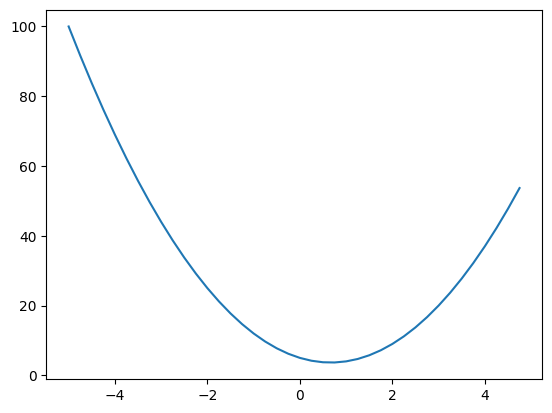

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Now, we will consider the tangent line of the function at two point 2.

In [26]:
def derivative(x):
  return 6*x - 4

def tangent_line(x,x0):
  return f(x0) + derivative(x0) * (x - x0)

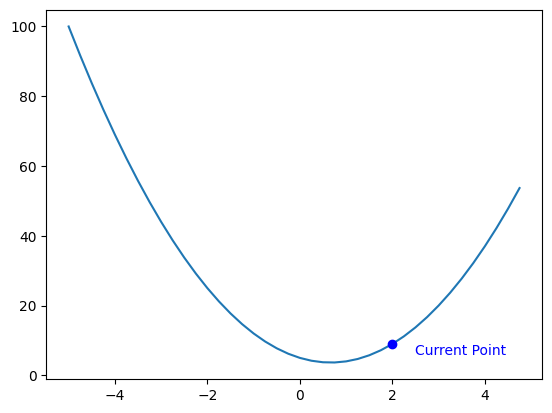

In [64]:
cur_x = 2
cur_y = f(cur_x)
plt.scatter(cur_x, cur_y, color='blue', zorder=5)
plt.text(cur_x + 0.5, cur_y - 3, "Current Point", color='blue')

plt.plot(xs, ys)

Now, if we want to move to the global minimum (in this case, our function is simple, it only have global minimum), we just need to move in the oposite to the direction of the derivative, we do this by subtract 2 by $α$$f'(2)$ (where $α$ is learning rate of the model or we can consider it as a factor which we will control the step of we that we move).

So, let's choose $α$ = 0.1, hence, the next point is (1.2, 4.52) which closer to the minimum (at (2/3,11/3) ) than (2,9).

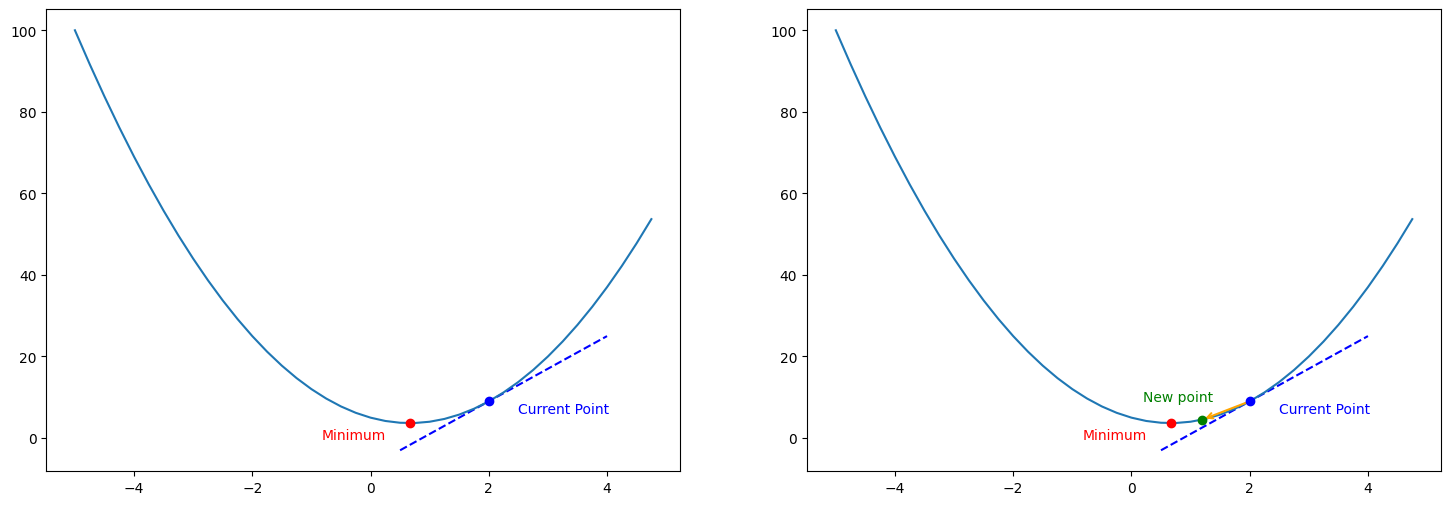

In [71]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# First plot (cell 1) on the left
x_tangent_1 = np.arange(0.5, 4.5, 0.5)
y_tangent_1 = tangent_line(x_tangent_1, 2)
ax1.plot(x_tangent_1, y_tangent_1, 'b--')

cur_x = 2
cur_y = f(cur_x)
ax1.scatter(cur_x, cur_y, color='blue', zorder=5)
ax1.text(cur_x + 0.5, cur_y - 3, "Current Point", color='blue')

min_x = 2/3
min_y = f(min_x)
ax1.scatter(min_x, min_y, color='red', zorder=5)
ax1.text(min_x - 1.5, min_y - 4, "Minimum", color='red')

# Generate the original function values for plotting
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

ax1.plot(xs, ys)

# Second plot (cell 2) on the right
x_tangent_1 = np.arange(0.5, 4.5, 0.5)
y_tangent_1 = tangent_line(x_tangent_1, 2)
ax2.plot(x_tangent_1, y_tangent_1, 'b--')

cur_x = 2
cur_y = f(cur_x)
ax2.scatter(cur_x, cur_y, color='blue', zorder=5)
ax2.text(cur_x + 0.5, cur_y - 3, "Current Point", color='blue')

new_x = 1.2
new_y = f(new_x)
ax2.scatter(new_x, new_y, color='green', zorder=5)
ax2.text(new_x - 1, new_y + 4.5, "New point", color='green')

ax2.annotate("",
             xy=(new_x, new_y), xycoords='data',
             xytext=(cur_x, cur_y), textcoords='data',
             arrowprops=dict(arrowstyle="->", color='orange', lw=1.5),
             )

min_x = 2/3
min_y = f(min_x)
ax2.scatter(min_x, min_y, color='red', zorder=5)
ax2.text(min_x - 1.5, min_y - 4, "Minimum", color='red')

ax2.plot(xs, ys)

What we have done so far is call Gradient Descent, moving toward the minimum of the function in the opposite direction of the derivative, each step controled by the learning rate $α$.

Now, we are ready to move to next part.

# II. Class "Value"

In this section, we will implement a new data type call __Value__, the purpose we implement this class to is make a wrapper to our data and thus keep track of what actually happen to it (i.e what operation it is made from, what is the function of its, what is the derivative of the very last function to this variable,...). All of them will be discuss in this section.

We first take a look at the attribute of the new class __Value__:

- data: This is the current data that each node hold.
- grad: The Gradient of the very last funtion regarad to this variable (that $∇F/∇a$ which we assume the this node variable is a)
- _backward: Function use for Back Propagation, passing the gradient to its children.
- _prev: A set to keep track its children.
- _op: An attribute of type string to store the operation which produce this node (For ex: if c = a + b, c._op = "+").
- label: Name of the variable.

In [194]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='',label = ""):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        if (self.label == ""):
          out = Value(self.data + other.data, (self, other), '+')
        else:
          out = Value(self.data + other.data, (self, other), '+',label = self.label) # This case is for +=

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        if (self.label == ""):
          out = Value(self.data * other.data, (self, other), '*')
        else:
          out = Value(self.data * other.data, (self, other), '*', label = self.label) # This is is for *=

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

The following is the example code of simple expression c = a*b.

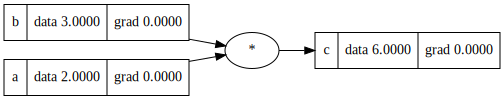

In [154]:
a = Value(2.0,label="a")
b = Value(3.0,label = 'b')
c = a * b; c.label = 'c'

draw_dot(c)

We will discuss the grad part of a node later, we will now consider what this class do.

When we call for __a = Value(2.0)__, we not only have a simple variable 'a' with float value 2.0, but also other attributes which helped for the Back Propagation process(again, we will talk about this in the next section, just keep in mind this).

In [93]:
print(a.data)
print(a.grad)
print(a._prev)
print(a._op)

2.0
0
set()



As you can see, "a" is a leaf node (that is, it node have any children) so the _prev will be an empty set, and _op will be "", it grad attribue is also 0 because we have not called for the backward of the very last function (i.e: c).
Similarlly for "b" too (except b.data is 3.0).

Let's take a look at "c":

In [94]:
print(c.data)
print(c.grad)
print(c._prev)
print(c._op)

6.0
0
{Value(data=2.0, grad=0), Value(data=3.0, grad=0)}
*


As you can see, c._prev is a set which contain two Value objects (corresponding to "a" and "b") and because c = a*b, c._op will be "*", the grad is 0 becuase this is the forward pass (the stage that we only calculate the result of the very last function "c", not calculate the gradient yet).

So briefly, this class will hold the value of the variable, the operations which make this variables as well as set of other variables which produce this variable.

Moreover, we also define the operation that can be use between __Value__ object which is adding, subtracting, multiplying, dividing, exponenting,... and also handle converting other data type to __Value__ object (like a + 2 which a is Value object). One more notice is that, we convert the division operations is get exponent by -1 which (so as you can see in the class, we mainly have three operation that is adding, multiplying and exponenting).

The code below test for some operation that we can do with __Value__ obeject (quite messy but good for illustration).

In [198]:
a = Value(-4.0,label="a")
b = Value(2.0,label="b")
c = a + b; c.label = "c"
d = a * b + b**3; d.label = "d"
c += c + 1
c += 1 + c + (-a)# -1.0
d += d * 2 + (b + a)
d += 3 * d + (b - a) # -2.0
e = c - d; e.label = "e" # 1.0
f = e**2; f.label = "f" # 1.0
g = f / 2.0
g += 10.0 / f; g.label = "g" # 10.5

In [199]:
print(a.label,a.data)
print(b.label,b.data)
print(c.label,c.data)
print(d.label,d.data)
print(e.label,e.data)
print(f.label,f.data)
print(g.label,g.data)

a -4.0
b 2.0
c -1.0
d -2.0
e 1.0
f 1.0
g 10.5


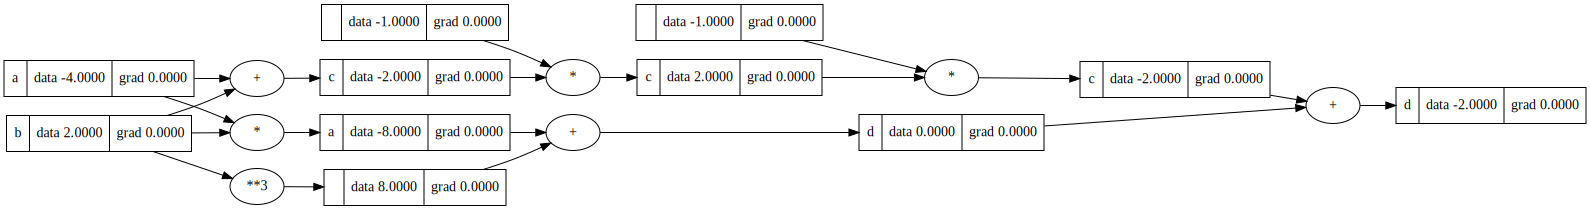

In [202]:
a = Value(-4.0,label="a")
b = Value(2.0,label="b")
c = a + b; c.label = "c" #-2.0
d = a * b + b**3; d.label = "d" # 0.0
d -= -c

draw_dot(d)

In this section, we have consider the implementation half of the class __Value__, specifically, attributes and operation on the __Value__ object. We are ready to move to the most interesting part, __Back Propagation__.

# III. Back Propagation

Remeber in section __II__, each node will have an attribute call "grad". As mention before, we will use this attribute to store (precisely accumulate) the gradient of the very last function with respect to the variable of the node.

To have a better look, let's consider the following example:

In [203]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, grad=0)

The expression of L is L = (a*b + c) *d, which have four free variables a,b,c and f. The forward pass is the process we get the input, put all of them to the function to get the result. Then, after having the result of the function, we can do the backward pass by consecutively find the Gradient of each variable (not only free variable like a,b,c,d, but also for variables like e,d). That is, we will find:

- $∇L/∇f$

- $∇L/∇d$

- $∇L/∇e$

-  $∇L/∇c$

- $∇L/∇a$

- $∇L/∇b$

Remark, our goal in doing this is to optimize the model by update the model parameters such that it will minimize the loss function, and we do that by finding the direction (gradient) in which each weight should move (or change). That is, when we done finding these gradient, we will do like: a - $α$$∇L/∇a$ as before.

Beside that, you may wondering why we need to calculate the gradient of the variables e and d right, isn't we just need to calculate directly the gradient for a,b,c and f. That correct, but now the magic of calculus come in, that is the Chain Rule.

## Chain Rule

The Chain Rule tell us that:

If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as, we will have:

$\frac{∇z}{∇x}$ = $\frac{∇z}{∇y}$.$\frac{∇y}{∇x}$

So, instead of explore the whole expression of L and take derivative step by step, we can do directly as below:

$\frac{∇L}{∇a}$ = $\frac{∇L}{∇e}$.$\frac{∇e}{∇a}$

This is the reason why we will calculate the gradient for all the variables not just the free one. At each time, a node will have an accumulate gradient itself (from the above node), these accumulate gradient will fall back to its childrens node (corresponding to the expression of the current node, we will have different amount of gradient fall back).

You can imagine it as the from very last function, the gradient will fall back to the previous node, and for each node, the gradient continue to fall back to others. In the end, what we have is a node not only have the data, but also the gradient that fall back from the very last function.

We call this is Back Propagation.

## Back Propagation

We have construct the function L = (a * b + c)*d, let call the backward() function to do the Back Propagation.

In [204]:
L.backward()

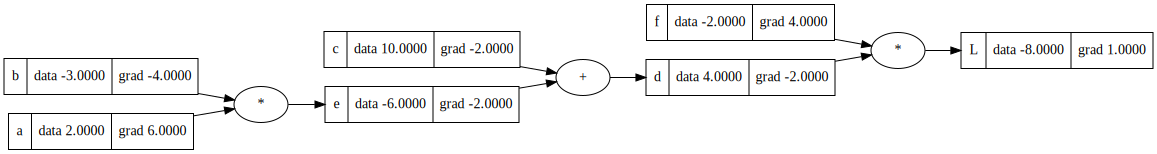

In [205]:
draw_dot(L)

As you can see in the diagram, the grad attribute in each node now have value, that is the gradient - the derivative of L corresponding to each variable.

Consider the last node L, this is the root node so $∇L/∇L$ = 1 thus grad = 1.0

Then, you can see that, its two children node d,f have grad = 4.0 and -2.0, respectively. Precisely, that is

- $\frac{∇L}{∇f} $ = d = 4.0

- $\frac{∇L}{∇d} $ = f = -2.0

Then because d = c + e, we will have:

- $\frac{∇d}{∇c} $ = 1.0

- $\frac{∇d}{∇e} $ = 1.0

And thus, by the Chain Rule we will have:

- $\frac{∇L}{∇c}$ = $\frac{∇L}{∇d}$.$\frac{∇d}{∇c}$ = -2.0 x 1.0 = -2.0

- $\frac{∇L}{∇e}$ = $\frac{∇L}{∇d}$.$\frac{∇d}{∇e}$ = -2.0 x 1.0 = -2.0

The process continue until the gradient fall back to all the leaf node (node that does not have any children). Then, after the Backward pass, we will update the weights and bias of the model as we do in section __I__ (with the control of learning rate parameter).

So far, we have talk about Back Propagation and how it works. We can start to train a simple MLP - (MultiLayer Perceptron).

# IV. Simple MLP classification

In [207]:
class Module:

    def zero_grad(self): # reset the gradient
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act # apply activation function or not

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

The above code implement the MLP class from scrath (this is a simple version of the actual one in Keras library) with the two class Layer and Neuron. We also have a special class call Module (which use for reset the gradient to 0 each time we done a forward and backward iteration when training model).

Let's load the Toy dataset.

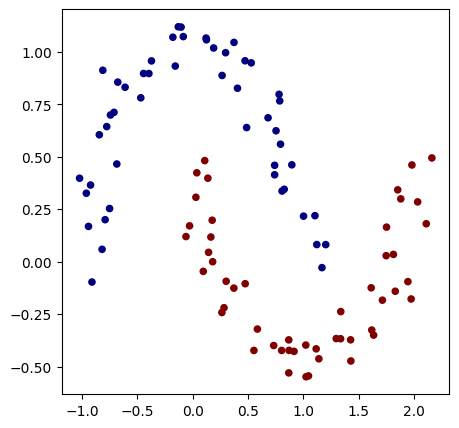

In [239]:
np.random.seed(1337)
random.seed(1337)

# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [240]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters())) # In this case 16*3 + 16*17 + 17 = 337

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


We take a look at the model parameters which is initilally randomed.

In [245]:
param_initial = model.parameters()

# The first neuron in the first layer parameter (the bias initialize to 0)
for i in param_initial[:3]:
  print(i.data)

0.23550571390294128
0.06653114721000164
0


Now, we will load the create data for training model as well as implement the loss method to evaluate the mode.

In [246]:
def load_data(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    return Xb,yb,[list(map(Value, xrow)) for xrow in Xb] # convert to Value object [Value(), Value(),..]

def loss():

    Xb, yb, inputs = load_data()

    # forward the model to get scores
    scores = list(map(model, inputs)) # [Value(), Value(),..] but now each is output of the model

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4 # notice alpha is not 1/2 in this case, it control how strong we want the regularizaztion
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


The loss function we will use to measure model performance (and also for Back Propagation) is:

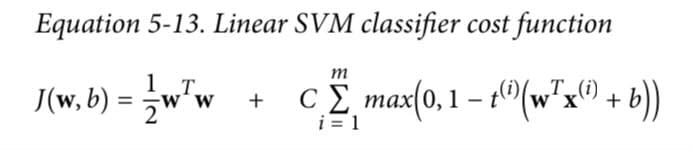

Now, we can start training the model. Precisely, we will do 100 time forward and backward pass, each time, we update the model parameters as we do earlier, we also keep track of the loss throughout each iteration to see if any problem (like overfitting or dead neuron,...) in the training process.

In [247]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad() # reset to zero gradient before calling the backward pass
    total_loss.backward() # call the backward pass to get the accumulated gradient

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad # moving toward the optimum

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.723590533697202, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584202, accuracy 82.0%
step 4 loss 0.3692793385976538, accuracy 84.0%
step 5 loss 0.313545481918522, accuracy 86.0%
step 6 loss 0.2814234349772434, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.25671472860574157, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658041, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.21560951851922946, accuracy 91.0%
step 13 loss 0.23090378446402737, accuracy 93.0%
step 14 loss 0.2015215122789944, accuracy 92.0%
step 15 loss 0.2257450627928223, accuracy 93.0%
step 16 loss 0.194479875962041, accuracy 92.0%
step 17 loss 0.2108949619924637, accuracy 93.0%
step 18 loss 0.159830773563036, accuracy 94.0%
step 19 loss 0.18453748746883927, accuracy 93.0%
step 20 loss 0.18977522856087634, accuracy 91.

As you can see, the model update itself every step, moving step by step to minimize the loss, which we see the loss reduce gradually from 1.7 to 0.01 at the end of the training.

In [250]:
param_trained = model.parameters()

# The first neuron in the first layer parameter after the model get trained
for i in param_trained[:3]:
  print(i.data)

-0.0761275947961443
0.2505645869095168
-0.23471352356143418


The weight of the model get updated (although the model loss in training process told us that but just a little check on it).

We now visualize the margin that produce by the model.

(-1.548639298268643, 1.951360701731357)

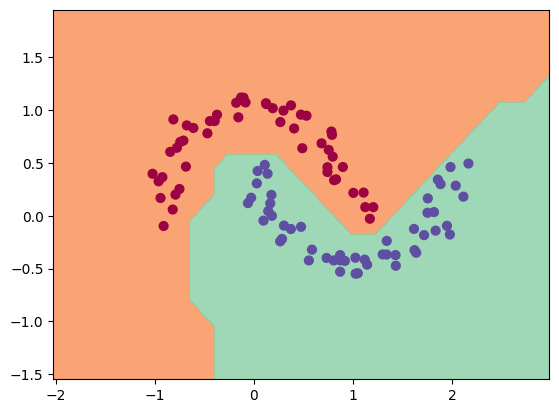

In [248]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

It look pretty good, right?

# V. Conclusion

- So far, we have implement a simple version of Tensors (maybe not as strong as the one of TensorFlow) but it have help us to figure out how variables are store and what they store themself. Moreover, we also take a deeper look on how the model get train and update their parameter through out Back Propagation. And beyond that, we also implement a simple version of MLP which provide us a more detail about how these neuron network  work.

- A great thank to __Andrej Kaparthy__ for inspise me a lot to do this notebook and the repo also. Most of the code in the notebook is of __Andrej Kaparthy__, I just modify a little bit in the __Value__ class for a better (maybe hehe) and also I adding some explaination for on the road and reconstruct the structure of the repo lecture of him.

- Andrej Karpathy's micrograd material:

>> [Andrej Karpathy's micrograd repo](https://github.com/karpathy/micrograd)

>> [Andrej Karpathy's The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0?si=giG-cNp3i0chlrn3)




